# Условие

В рамках этой части задания ответьте в ноутбуке на следующие вопросы:

Общее исследование данных: проверить размеры таблицы, число столбцов, количество пропусков в столбцах (1 балл).

Однофакторный анализ: по каждому столбцу посмотреть его распределение. Если есть пропуски и ошибочные значения - обработать их. Посмотреть связь с целевой переменной (3 балла).

Построить матрицу корреляций (или ее аналог для категориальных признаков): использовать корреляции, тест $\chi^2(X,Y)$ , ANOVA (2 балла).

Провести анализ целевой переменной - на какое распределение больше всего похожа ее гистограмма? Какие проблемы в связи с этим могут возникнуть при обучении моделей? (1 балл)

Увеличить размер данных простым дублированием до 1_000_000 строк в датасете. Провести сравнение скорости работы Pandas и Polars на увеличенном датасете по параметрам:
* загрузка данных (1 балл)
* фильтрация данных (1 балл)
* агрегация данных (1 балл)

Выбрал датасет по морси

In [ ]:
!pip install polars
!pip install phik -q

In [ ]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import shapiro
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
ABALONE_DATASET_PATH = 'https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv'

Оптимизируем использование памяти.

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
df = import_data(ABALONE_DATASET_PATH)
df.sample(5)

Memory usage of dataframe is 0.29 MB
Memory usage after optimization is: 0.06 MB
Decreased by 77.7%


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3445,I,0.495117,0.399902,0.145020,0.578125,0.254395,0.130493,0.164551,8
2097,M,0.425049,0.330078,0.080017,0.361084,0.134033,0.082520,0.125000,7
502,F,0.620117,0.469971,0.224976,1.115234,0.377930,0.214478,0.360107,15
1420,F,0.709961,0.549805,0.170044,NaN,0.743164,0.344971,0.449951,11
2515,F,0.469971,0.375000,0.119995,0.601562,0.276611,0.145508,0.135010,8


# Описание.
Predict the age of abalone from physical measurements

**Sex** - nominal - M, F, and I (infant)

**Length** - continuous - mm - Longest shell measurement

**Diameter** - continuous - mm - perpendicular to length

**Height** - continuous - mm - with meat in shell

**Whole weight** - continuous - grams - whole abalone

**Shucked weight** - continuous - grams - weight of meat

**Viscera weight** - continuous - grams - gut weight (after bleeding)

**Shell weight** - continuous - grams - after being dried

**Rings** - integer - +1.5 gives the age in years (target)

Link to the description of the original dataset.

**Задача:**

Прогнозирование возраста галиотисов по физическим измерениям.  Возраст морского ушка определяется путем разрезания оболочки через конус, окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения проблемы может потребоваться дополнительная информация, такая как погодные условия и местоположение (отсюда и наличие продуктов питания).


Из исходных данных были удалены примеры с отсутствующими значениями (большинство из которых имели прогнозируемое значение, отсутствующее), а диапазоны непрерывных значений были масштабированы.

# EDA

## Общее исследование данных.

Проверить размеры таблицы, число столбцов, количество пропусков в столбцах

Размер датасета

In [ ]:
df.shape

(4177, 9)

Информация о типах данных и пропусках

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             4177 non-null   category
 1   Length          4177 non-null   float16 
 2   Diameter        4078 non-null   float16 
 3   Height          4177 non-null   float16 
 4   Whole weight    4078 non-null   float16 
 5   Shucked weight  4177 non-null   float16 
 6   Viscera weight  4177 non-null   float16 
 7   Shell weight    4127 non-null   float16 
 8   Rings           4177 non-null   int8    
dtypes: category(1), float16(7), int8(1)
memory usage: 65.6 KB


У нас 9 столбцов. 4177 строк. Данных достаточно мало. Есть пропущенные значения. Категориальный признак - пол.

In [ ]:
cat_features = ['Sex']
targets = ['Rings']

num_features = [i for i in df.columns if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['Sex'], amount = 1
num_features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'], amount = 8
targets: ['Rings'], amount = 1


In [ ]:
df['Sex'].astype('category');

In [ ]:
df.isnull().mean() * 100

Sex               0.000000
Length            0.000000
Diameter          2.370122
Height            0.000000
Whole weight      2.370122
Shucked weight    0.000000
Viscera weight    0.000000
Shell weight      1.197031
Rings             0.000000
dtype: float64

Обработаем пропущенные значения. Т.к. их мало (< 5%), то заполним пропуски медианой.

In [ ]:
median_diameter = df['Diameter'].median()

df['Diameter'].fillna(median_diameter, inplace=True)

In [ ]:
median_whole_weight = df['Whole weight'].median()

df['Whole weight'].fillna(median_whole_weight, inplace=True)

In [ ]:
median_shell_weight = df['Shell weight'].median()

df['Shell weight'].fillna(median_shell_weight, inplace=True)

In [ ]:
# Проверка
df.isnull().any().any()

False

Основные числовые характеристики

In [ ]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523926,0.408203,0.139648,0.826660,0.359375,0.180664,0.239136,9.933684
std,0.120056,0.098145,0.041840,0.484619,0.221924,0.109619,0.138062,3.224169
min,0.075012,0.054993,0.000000,0.002001,0.001000,0.000500,0.001500,1.000000
25%,0.449951,0.350098,0.114990,0.447510,0.186035,0.093506,0.131470,8.000000
50%,0.544922,0.425049,0.140015,0.798340,0.335938,0.171021,0.234985,9.000000
75%,0.615234,0.479980,0.165039,1.141602,0.501953,0.252930,0.324951,11.000000
max,0.814941,0.649902,1.129883,2.826172,1.488281,0.759766,1.004883,29.000000


In [ ]:
df.describe(include='category')

,Sex
count,4177
unique,4
top,M
freq,1447


In [ ]:
# дубликаты отстутсвуют
df.duplicated().sum()

0

In [ ]:
df[df['Height'] == 0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.429932,0.340088,0.0,0.427979,0.206543,0.085999,0.114990,8
3996,I,0.314941,0.229980,0.0,0.134033,0.057495,0.028503,0.350586,6


Смущает значение высоты = 0. Но таких строк всего 2. Удалим такие строки.

In [ ]:
df = df[df['Height'] != 0]

In [ ]:
len(df[df['Height'] == 0])

0

Также сделаем ещё проверку, что вес внутренних органов или вес раковины или вес без раковины не превышает всего веса.

In [ ]:
df[(df['Whole weight'] <= df['Shucked weight']) | (df['Whole weight'] <= df['Viscera weight']) | (df['Whole weight'] <= df['Shell weight'])]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
519,F,0.344971,0.250000,0.090027,0.203003,0.078003,0.058990,0.234985,6
634,M,0.360107,0.294922,0.099976,0.210449,0.065979,0.052490,0.234985,9
691,I,0.254883,0.189941,0.075012,0.086487,0.034485,0.020493,0.234985,5
784,I,0.214966,0.155029,0.059998,0.052490,0.020996,0.016495,0.234985,5
814,I,0.314941,0.239990,0.085022,0.171509,0.070984,0.034485,0.234985,7
905,I,0.320068,0.239990,0.090027,0.157471,0.070007,0.026505,0.234985,5
1216,I,0.310059,0.224976,0.070007,0.105530,0.435059,0.014999,0.040009,5
1419,F,0.705078,0.569824,0.180054,0.798340,0.959961,0.419434,0.429932,12
1982,M,0.720215,0.564941,0.189941,0.798340,1.081055,0.430420,0.502930,11
2115,I,0.180054,0.130005,0.045013,0.027496,0.012497,0.010002,0.234985,3


Предположим, что это ошибочные данные. Т.к. их немного тоже удалим.

In [ ]:
df = df[~((df['Whole weight'] <= df['Shucked weight']) | (df['Whole weight'] <= df['Viscera weight']) | (df['Whole weight'] <= df['Shell weight']))]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4155 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             4155 non-null   category
 1   Length          4155 non-null   float16 
 2   Diameter        4155 non-null   float16 
 3   Height          4155 non-null   float16 
 4   Whole weight    4155 non-null   float16 
 5   Shucked weight  4155 non-null   float16 
 6   Viscera weight  4155 non-null   float16 
 7   Shell weight    4155 non-null   float16 
 8   Rings           4155 non-null   int8    
dtypes: category(1), float16(7), int8(1)
memory usage: 97.6 KB


In [ ]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4155.000000,4155.000000,4155.000000,4155.000000,4155.000000,4155.000000,4155.000000,4155.000000
mean,0.524414,0.408691,0.139771,0.829102,0.359619,0.180908,0.238892,9.948736
std,0.119324,0.097595,0.041595,0.483643,0.220825,0.109070,0.138062,3.221635
min,0.075012,0.054993,0.010002,0.002001,0.001000,0.000500,0.001500,1.000000
25%,0.449951,0.350098,0.114990,0.449707,0.187012,0.094482,0.131470,8.000000
50%,0.544922,0.425049,0.140015,0.798340,0.335938,0.171021,0.234985,9.000000
75%,0.615234,0.479980,0.165039,1.143555,0.502441,0.252930,0.324951,11.000000
max,0.814941,0.649902,1.129883,2.826172,1.488281,0.759766,1.004883,29.000000


## Однофакторный анализ.
По каждому столбцу посмотреть его распределение. Если есть пропуски и ошибочные значения - обработать их. Посмотреть связь с целевой переменной.

In [ ]:
df.columns = df.columns.str.replace(' ','_')

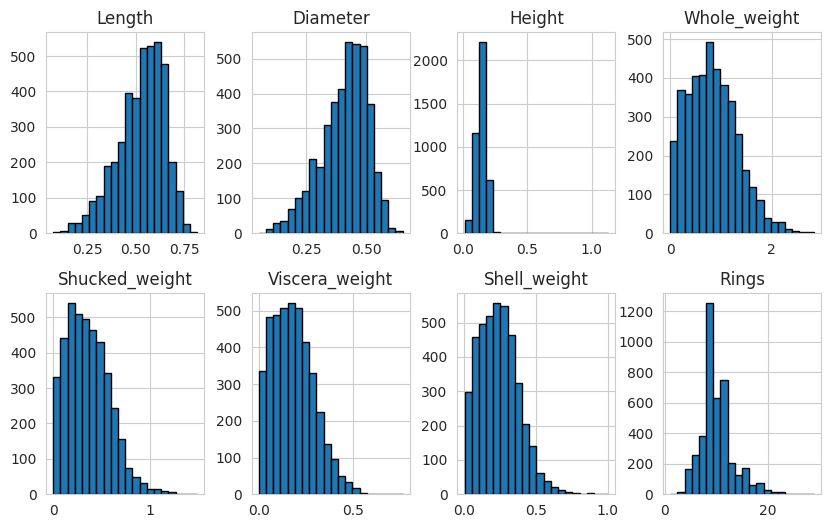

In [ ]:
df.drop("Sex", axis=1).hist(figsize=(10, 6), layout=(-1, 4), bins=20, edgecolor='black');

### Sex

In [ ]:
df['Sex'].value_counts()

M    1444
I    1260
F    1256
f     195
Name: Sex, dtype: int64

У нас есть странное значение 'f'. Предполагаем, что это ошибочное female. Заменим данные значения.

In [ ]:
df['Sex'] = df['Sex'].replace('f', 'F')

In [ ]:
df['Sex'].value_counts(normalize=True)

F    0.349218
M    0.347533
I    0.303249
Name: Sex, dtype: float64

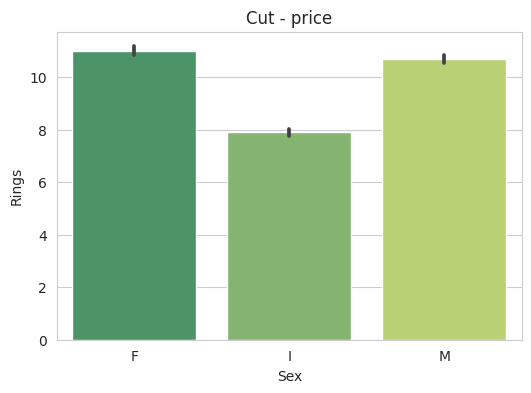

In [ ]:
plt.figure(figsize=(6,4))

sns.barplot(x='Sex', y='Rings', data = df, palette='summer')
plt.title('Cut - price')
plt.show();

In [ ]:
df.groupby('Sex').agg(Rings_mean=('Rings', 'mean'))

,Rings_mean
Sex,
F,11.004135
I,7.896032
M,10.679363


Ожидаемо, что средний возраст особей женского и мужского пола выше, чем у малолетних.

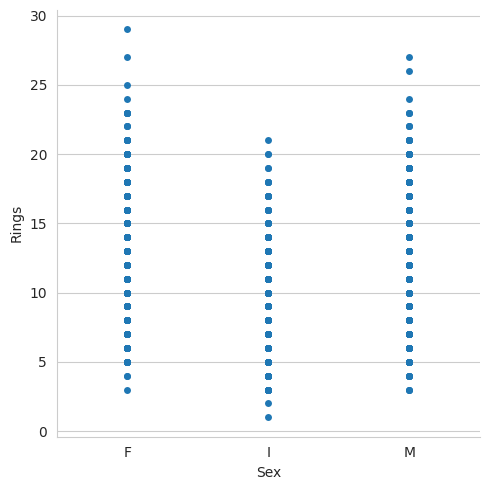

In [ ]:
sns.catplot(data=df, x="Sex", y="Rings", jitter=False)

Немного странно, что имеем достаточно возрастных малолетних.

In [ ]:
# Функция для отображения некоторых характеристик числовых данных
def numeric_features_eda(feat: str, hue: bool=True, verbose: bool = True) -> None:
    print(f'\033[1mmean\033[0m = {df[feat].describe()[1]}, \033[1mmin\033[0m = {df[feat].describe()[3]}, \033[1mmax\033[0m = {df[feat].describe()[7]}' )

    if hue:
        di = {'data': df,
            'x': feat,
            'y': 'Rings',
            'hue': 'Sex',
            'scatter_kws': {'s': 6, 'alpha': 0.8},
            'line_kws': {"lw":1, 'linestyle':'--'},
            # 'height': 4.5,
            'aspect': 3,
            'palette': 'Set1'}
    else:
        di = {'data': df,
            'x': feat,
            'y': 'Rings',
            'scatter_kws': {'s': 6, 'alpha': 0.8},
            'line_kws': {"lw":1, 'linestyle':'--', 'color': 'r'},
            'height': 4.5,
            'aspect': 3}


    if verbose:
      g = sns.lmplot(**di)
      g = sns.catplot(data=df,
                      y=feat,
                      height=3,
                      aspect=1,
                      kind="violin",).set_xticklabels(rotation=45, horizontalalignment="right");

    print(f'\033[1mКоэффициент корреляции\033[0m  = ', np.corrcoef(df[feat], df['Rings'])[0][1])

### Length

mean = 0.5244140625, min = 0.07501220703125, max = 0.81494140625
Коэффициент корреляции  =  0.5532208002535045


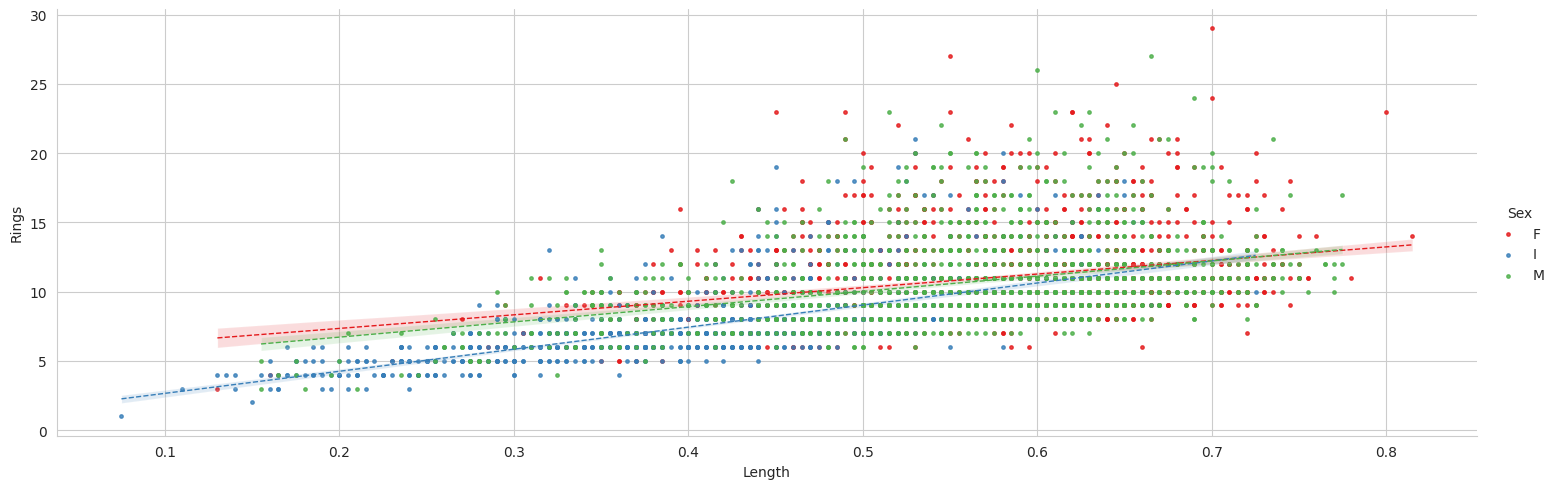

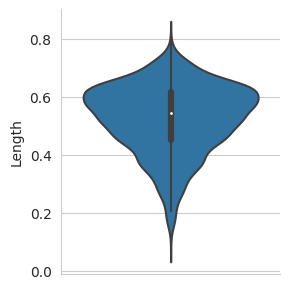

In [ ]:
numeric_features_eda(feat='Length')

Коэффициент корреляции позволяет говорить о линейной взаимосвязи длины и возраста. Согласно регрессионной прямой можно видеть, что возраст прямопропорционален длине. Также видно, что эта зависимость сохраняется и при разбиении на группы по полу.

### Diameter

mean = 0.40869140625, min = 0.05499267578125, max = 0.64990234375
Коэффициент корреляции  =  0.559887227600354


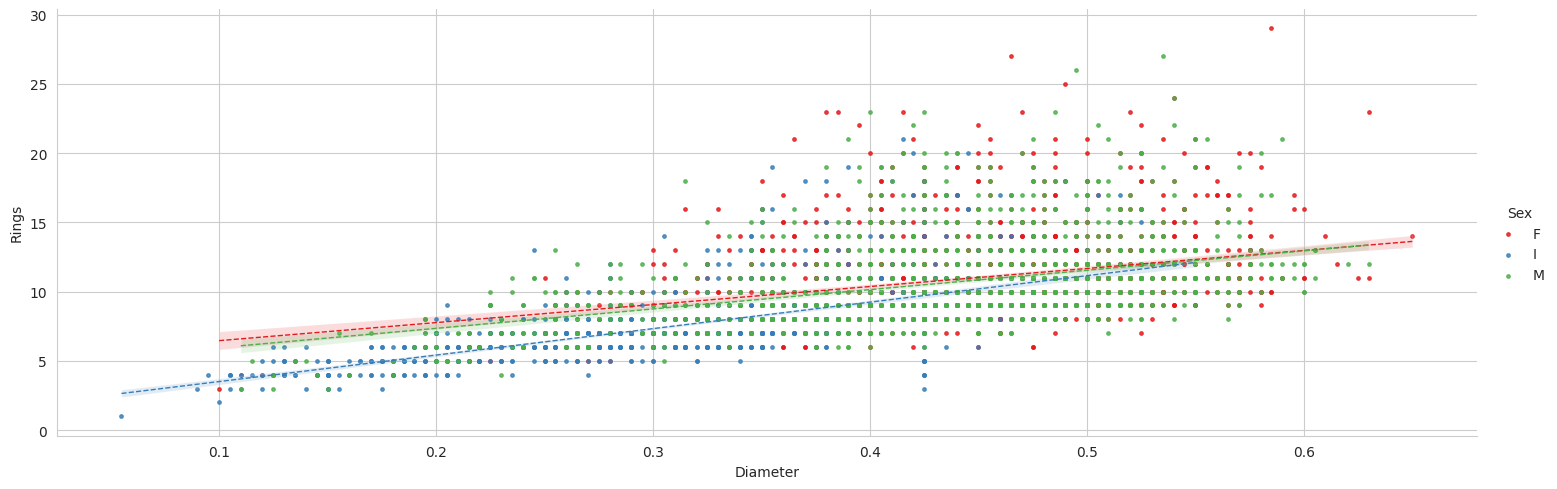

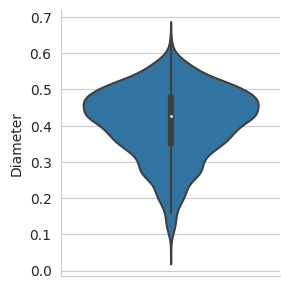

In [ ]:
numeric_features_eda(feat='Diameter')

Коэффициент корреляции позволяет говорить о линейной взаимосвязи диаметра и возраста. Согласно регрессионной прямой можно видеть, что возраст прямопропорционален диаметру. Также видно, что эта зависимость сохраняется и при разбиении на группы по полу.

### Height

mean = 0.1397705078125, min = 0.01000213623046875, max = 1.1298828125
Коэффициент корреляции  =  0.5545933700614392


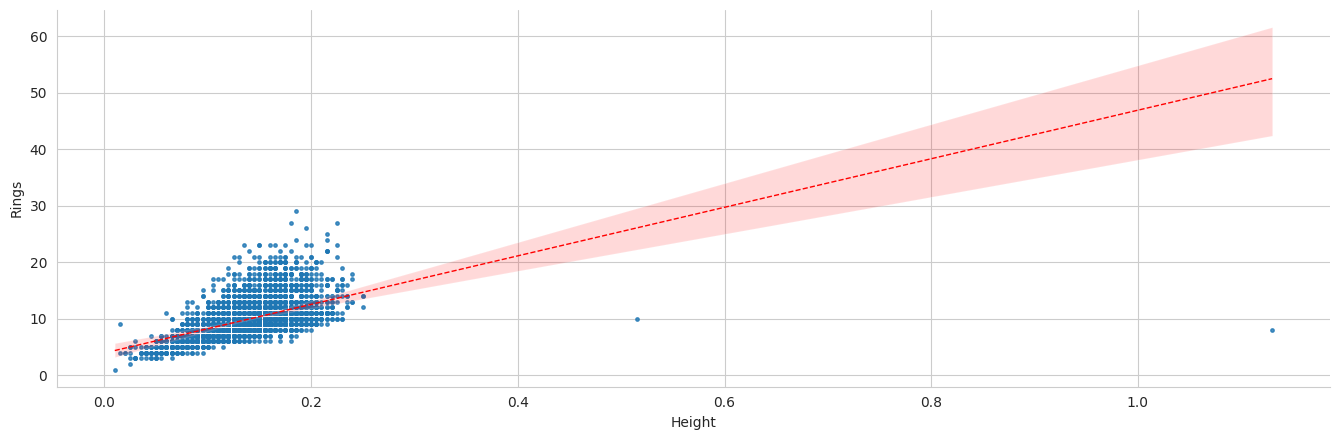

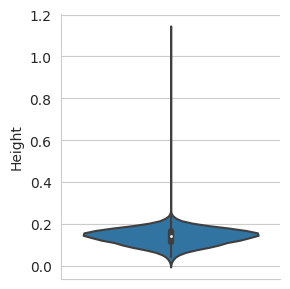

In [ ]:
numeric_features_eda(feat='Height', hue=False)

Вообще характеристики размера связаны друг с другом.

Коэффициент корреляции позволяет говорить о линейной взаимосвязи высоты и возраста. Согласно регрессионной прямой можно видеть, что возраст прямопропорционалена высоте.

Из интересного мы имеем два выброса в размере высоты.

### Whole weight

mean = 0.8291015625, min = 0.0020008087158203125, max = 2.826171875
Коэффициент корреляции  =  0.5289646799693596


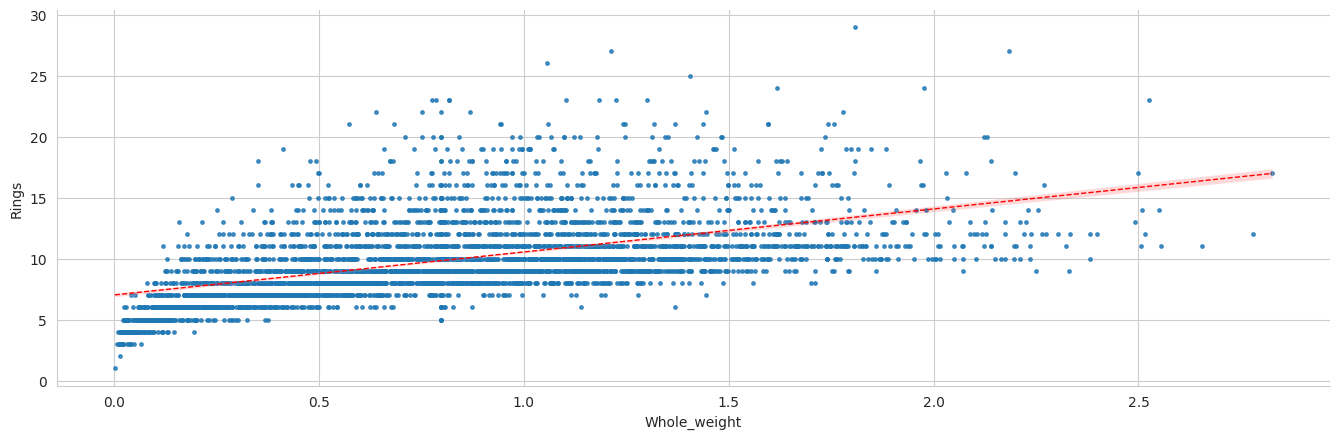

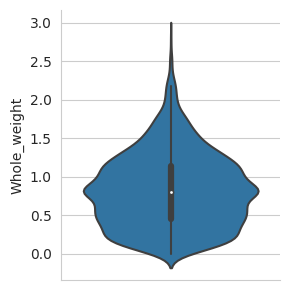

In [ ]:
numeric_features_eda(feat='Whole_weight', hue=False)

Опять же для полного веса также видим взаимосвязь с целевой переменной.

### Shucked weight (вес без раковины)

mean = 0.359619140625, min = 0.0010004043579101562, max = 1.48828125
Коэффициент корреляции  =  0.41913237798327974


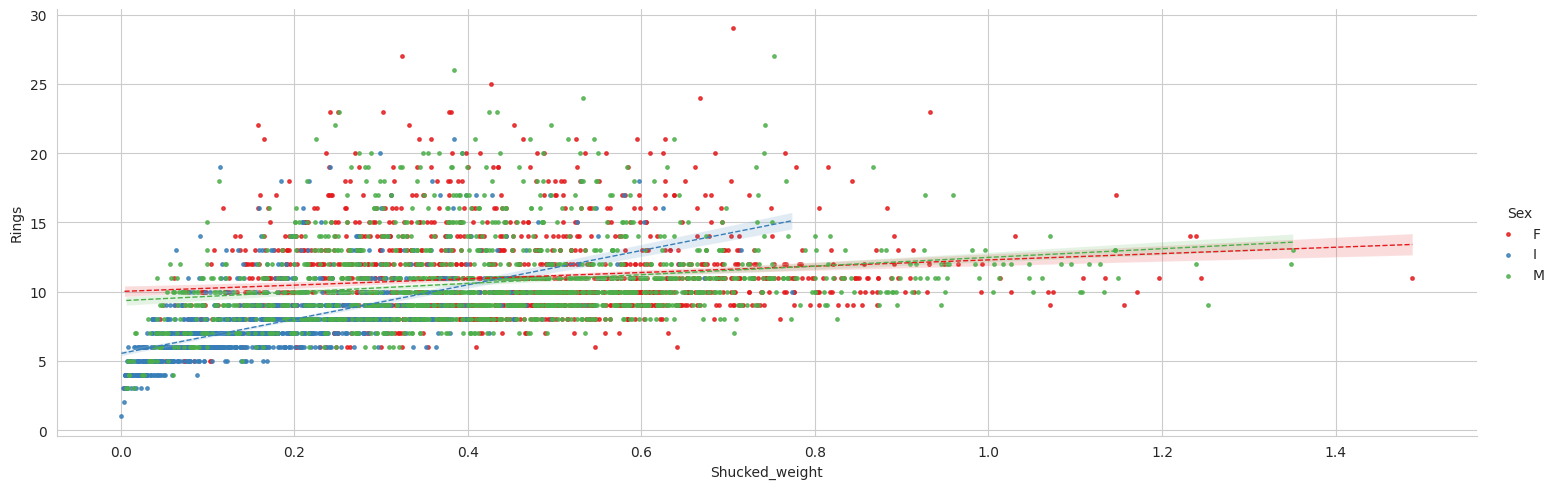

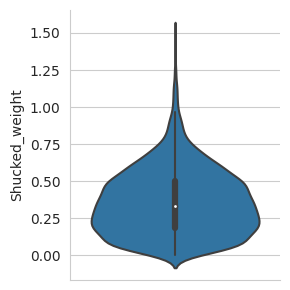

In [ ]:
numeric_features_eda(feat='Shucked_weight', hue=True)

 ### Viscera weight (висцеральный вес)

mean = 0.180908203125, min = 0.0005002021789550781, max = 0.759765625
Коэффициент корреляции  =  0.5012046719659079


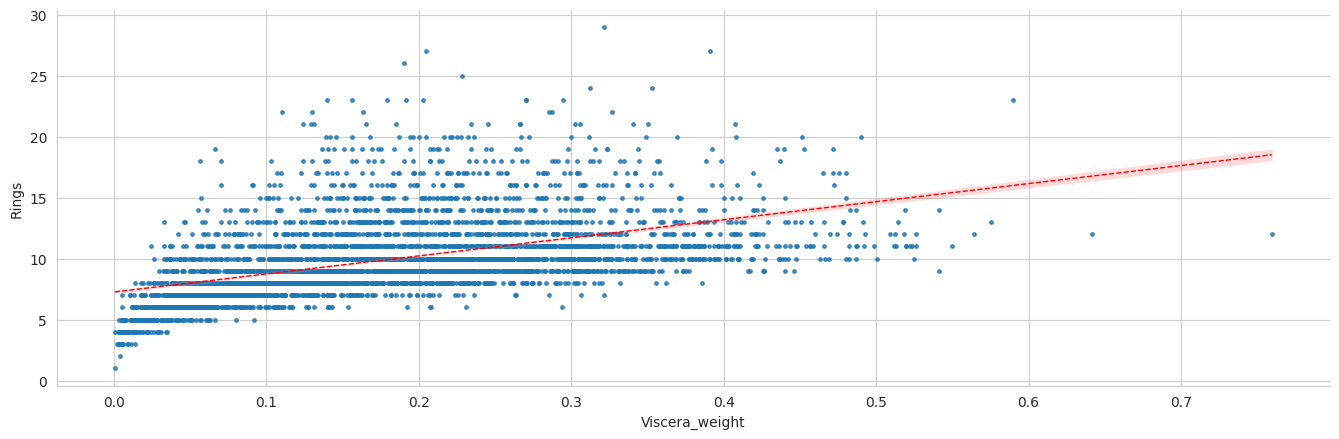

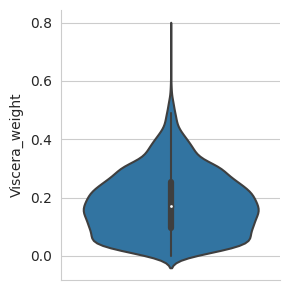

In [ ]:
numeric_features_eda(feat='Viscera_weight', hue=False)

Возраст также прямопропорционален весу внутренних органов.

### Shell weight (вес оболочки)

mean = 0.2388916015625, min = 0.0015001296997070312, max = 1.0048828125
Коэффициент корреляции  =  0.6239474884496257


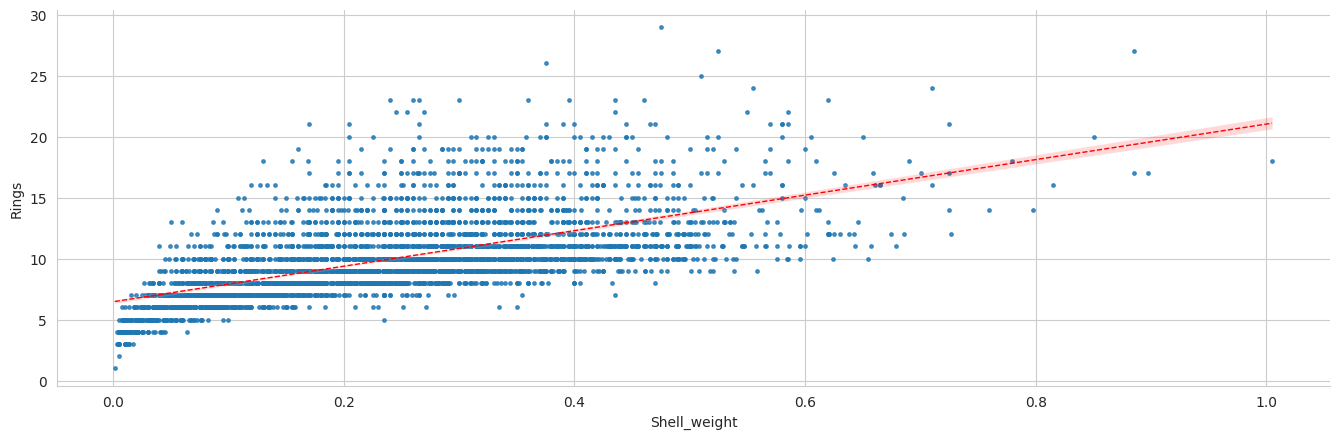

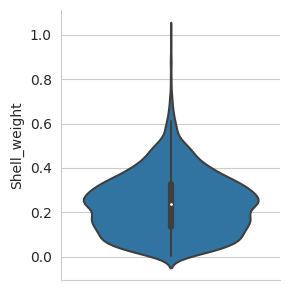

In [ ]:
numeric_features_eda(feat='Shell_weight', hue=False)

## Построить матрицу корреляций
(или ее аналог для категориальных признаков): использовать корреляции, тест $\chi^2(X,Y)$ , ANOVA (2 балла).

### Числовые столбцы.

#### Корреляция Пирсона

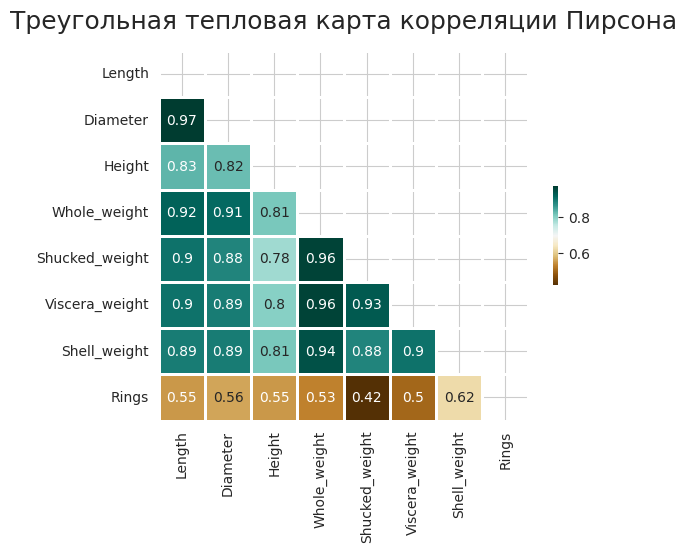

In [ ]:
sns.set_style("whitegrid")

# Воспользуемся функциями np.triu, чтобы изолировать верхний треугольник (np.tril нижний)
# функция np.ones_like() изменит все изолированные значения на 1.
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    df.corr(numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,

    mask=mask,
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции Пирсона", fontdict={"fontsize": 18}, pad=16
);

С целевой переменной у нас коррелируют все признаки. Больше всего - весс раковины, меньше - вес без раковины.

#### Корреляция Спирмена

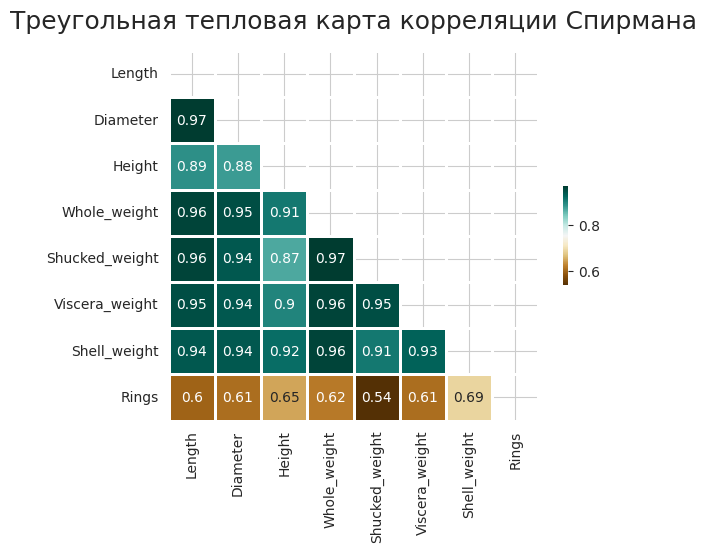

In [ ]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    df.corr(numeric_only=True, method='spearman').round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,

    mask=mask,
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции Спирмана", fontdict={"fontsize": 18}, pad=16
);

С целевой переменной у нас коррелируют все признаки. Больше всего - высота, меньше - вес без раковины.

#### Корреляция Кендалла

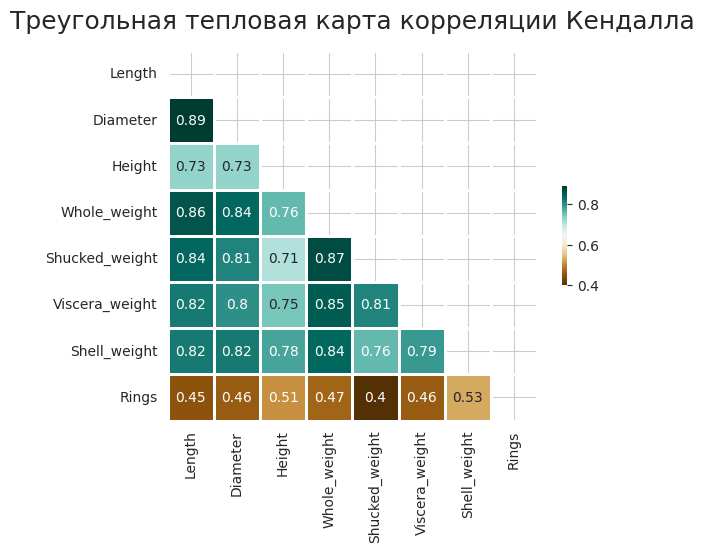

In [ ]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    df.corr(numeric_only=True, method='kendall').round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,

    mask=mask,
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции Кендалла", fontdict={"fontsize": 18}, pad=16
);

С целевой переменной у нас коррелируют все признаки. Больше всего - высота, меньше - вес без раковины.

### Категориальные признаки.

В данном датасете только один категориальный признак, поэтому нельзя применить V-меру Крамера.

#### Anova

In [ ]:
sex_data = df[['Sex', 'Rings']]
CategoryGroupLists = sex_data.groupby('Sex')['Rings'].apply(list)

AnovaResults = f_oneway(*CategoryGroupLists)
AnovaResults = f_oneway(*CategoryGroupLists)

print('P-Value for Anova is: ', AnovaResults[1])

if AnovaResults[1] >= 0.05:
    print('Features are NOT correlated')
else:
    print('Features are correlated')

P-Value for Anova is:  5.214821266401025e-178
Features are correlated


In [ ]:
Data = []

for c1 in df.columns:
    for c2 in df.columns:
        if df[c1].dtype == 'category' and df[c2].dtype != 'category':
            CategoryGroupLists = df.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Height,Yes
3,Sex,Whole_weight,Yes
4,Sex,Shucked_weight,Yes
5,Sex,Viscera_weight,Yes
6,Sex,Shell_weight,Yes
7,Sex,Rings,Yes


Корреляция меньше уровня 0,05. Поэтому считаем, что признаки скоррелированы.

#### Phik

interval columns not set, guessing: ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']


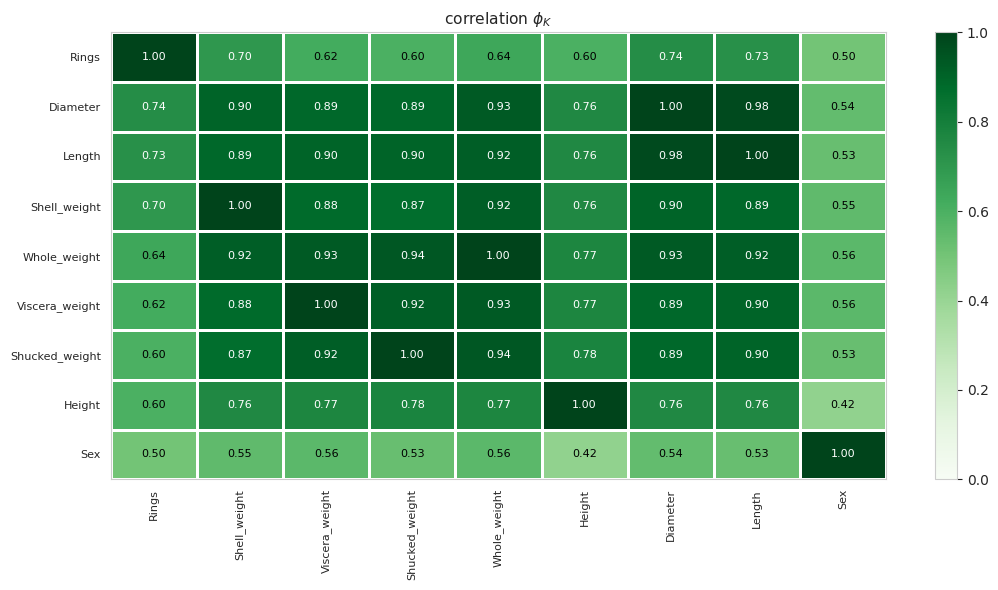

In [ ]:
phik_overview = df.phik_matrix().round(2).sort_values('Rings')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

Метод позволяется вычислять взаимосвязи между различными типами признаков (категориальными, непрерывными и их комбинациями), в нем используются передовые статистические методики и его легко применить с библиотекой phik.

Суть метода базируется на подсчете хи-квадрат статистики, затем ее трансформации в нечто подобное коэффициенту корреляции только на отрезке от 0 (нулевая взаимосвязь) до 1 (максимальная взаимосвязь). С этой целью разработчики считают аналогичную хи-квадрат статистику для различных значений корреляции p случайных величин из двумерного нормального распределения. Возвращается p двумерного распределения, соответствующее найденной хи-квадрат статистике между заданными признаками.

С нашей переменной больше всего коррелируют: диаметр и длина. Меньше всего - пол.

## Провести анализ целевой переменной
На какое распределение больше всего похожа ее гистограмма? Какие проблемы в связи с этим могут возникнуть при обучении моделей?

<Axes: xlabel='Rings', ylabel='Count'>

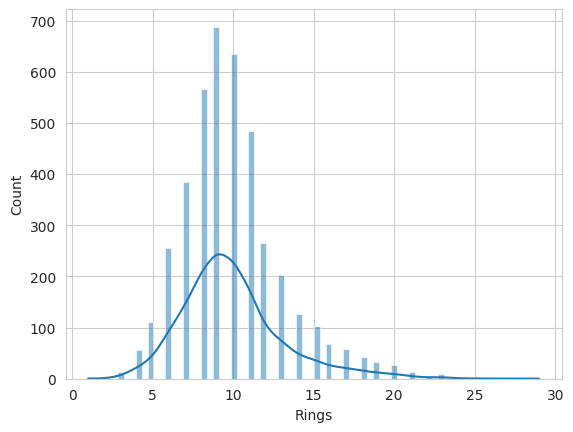

In [ ]:
sns.histplot(df.Rings, kde=True)

Просто взглянув на эту гистограмму, мы можем сказать, что набор данных не имеет «колокольчатой формы» и не имеет нормального распределения. Имеем длинный хвост для большого возраста.

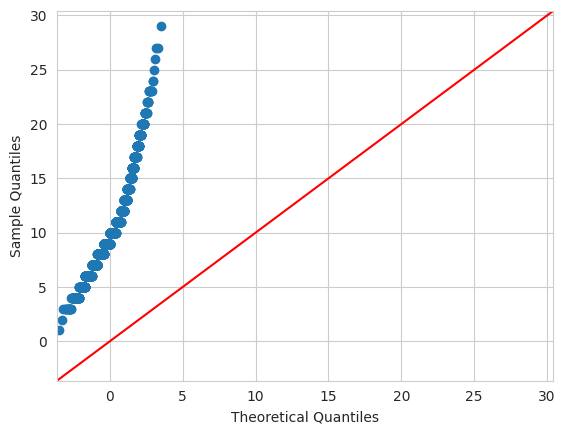

In [ ]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(df['Rings'].values, line='45')

plt.show()

In [ ]:
#perform Shapiro-Wilk test for normality
shapiro(df['Rings'].values)

ShapiroResult(statistic=0.9306268692016602, pvalue=3.036193382652581e-40)

Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу теста Шапиро-Уилка.

Это означает, что у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

<Axes: xlabel='Rings'>

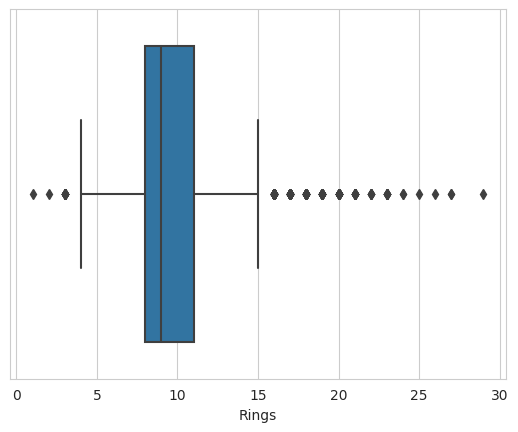

In [ ]:
sns.boxplot(x=df.Rings, orient='h')

У нас мало больших значений Rings.

Большинство моделей плохо работают не с нормальным распределением. Поэтому возможно потребуется выбирать более сложные, чем линейная регрессия модель. Либо пытаться логарифмировать.

In [ ]:
len(df[df['Rings'] >= 15]) / len(df)

0.08760529482551144

<Axes: xlabel='Rings', ylabel='Count'>

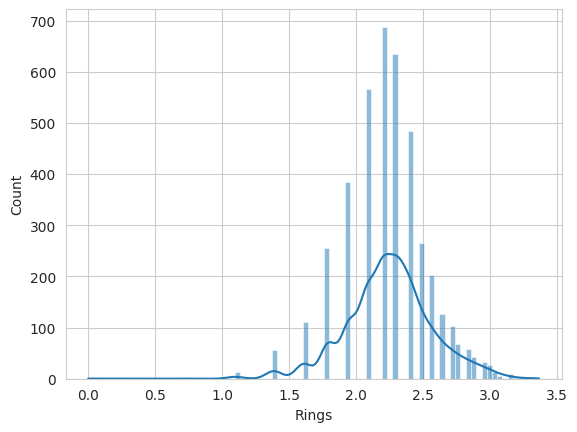

In [ ]:
sns.histplot(data = np.log(df['Rings']), kde = True)

Нет, особо логирование не помогло. Если для больших значений Rings мы получаем улучшение, то для малых - улучшения нет.

In [ ]:
y = df['Rings']
X = df.drop(['Rings', 'Sex'], axis=1)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

model = LogisticRegression(solver='liblinear')
model.fit(X, y)

LogisticRegression(solver='liblinear')

In [ ]:
pred = model.predict(X)

In [ ]:
mean_absolute_error(y[y < 15], pred[y < 15])

1.2223687681350568

In [ ]:
mean_absolute_error(y[y >= 15], pred[y >= 15])

6.791208791208791

Да, для значений Rings больше 15 имеем и большую ошибку.

# Cравнение скорости работы Pandas и Polars

Провести сравнение скорости работы Pandas и Polars на увеличенном датасете по параметрам.

Увеличить размер данных простым дублированием до 1_000_000 строк в датасете.

In [ ]:
df_big = df.copy()

for i in range(240):
    df_big = pd.concat([df_big, df])

df_big.to_csv("abalone_big.csv", index=False)

In [ ]:
df_big.shape, df.shape

((1001355, 9), (4155, 9))

## Загрузка данных

In [ ]:
%%time

df = pd.read_csv("abalone_big.csv")

CPU times: user 1.03 s, sys: 79.4 ms, total: 1.11 s
Wall time: 1.18 s


In [ ]:
%%time

df_pl = pl.read_csv("abalone_big.csv")

CPU times: user 765 ms, sys: 141 ms, total: 906 ms
Wall time: 652 ms


Polars загружает данные быстрее.

## Фильтрация данных

In [ ]:
# Pandas
%%timeit

df[['Length', 'Whole_weight']]

4.37 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Polars
%%timeit

df_pl[['Length', 'Whole_weight']]

18.1 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Видим, что даже в простом отборе колонок Polars достаточно сильно выигрывает.

In [ ]:
# Pandas
%%timeit

df.query('Diameter > 0.4')

45.5 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Polars
%%timeit

df_pl.filter(pl.col('Diameter') > 0.4)

22.1 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Polars быстрее фильтрует по одному признаку.

In [ ]:
# Pandas
%%timeit

df[(df['Sex'] == 'I') & (df['Rings'] > 10)]

77.2 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Polars
%%timeit

df_pl.filter((pl.col('Sex') == 'I') & (pl.col('Rings') > 10))

16.4 ms ± 8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Опять Polars выигрывает по скорости фильтрации по двум колонкам.

Во всех тестах Polars фильтровал быстрее примерно в 2 раза.

## Агрегация данных

In [ ]:
# Pandas
%%timeit

df.groupby('Sex').agg(Length_mean=('Length', 'mean'), Whole_weight_median=('Whole_weight', 'median'))

101 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Polars
%%timeit

df_pl.groupby('Sex').agg([pl.mean('Length'), pl.median('Whole_weight')])

50 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# lazy operations
%%timeit

q = (
    df_pl
    .lazy()
    .groupby(by='Sex')
    .agg(
        [
            pl.col('Length').mean(),
            pl.col('Whole_weight').median()
        ]
    )
)

35.3 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit

q.collect()

57.8 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


В моих тестах Polars постоянно выигрывал по скорости у Pandas.